In [1]:
# Imports
from dataloader import get_utkface_loaders
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from models import *

In [ ]:
# Load data
target_column = 'age'
train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=64, num_train=10000, num_valid=2000, num_test=2000)

100%|██████████| 23708/23708 [00:00<00:00, 646754.86it/s]


In [ ]:
print("Train class distribution:", train_labels)

Train class distribution: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1

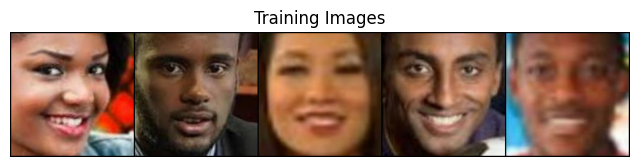

Age: [22. 34. 31. 26. 24.]


In [3]:
# Print 5 images with the age label
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(images[:5], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
print('Age:', labels[:5].numpy())

In [4]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [5]:
def check_accuracy_classification(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [6]:
print_every = 5000
def train_classification(model, optimizer, epochs=5):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_classification(valid_loader, model)
                print()
    return check_accuracy_classification(valid_loader, model)

In [7]:
num_class = 20
target_column = 'age_class'
train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=64, num_train=1000, num_valid=200, num_test=200)
model_resenet_class = ResNetClassification(num_class=num_class)
optimizer = optim.Adam(model_resenet_class.parameters(), lr=1e-3)
train_classification(model_resenet_class, optimizer, epochs=2)

100%|██████████| 23708/23708 [00:00<00:00, 491020.67it/s]


Got 20 / 20 correct (100.00)


1.0

In [8]:
# Check the accuracy of the model
check_accuracy_classification(test_loader, model_resenet_class)

Got 20 / 20 correct (100.00)


1.0

In [16]:
def check_accuracy_regression(loader, model): 
    num_correct = 0
    num_samples = 0
    mean_error = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            # Correct if prediction is within 5 years of the actual age
            num_correct += (torch.abs(scores - y) <= 2.5).sum()
            mean_error += torch.abs(scores - y).sum()
            num_samples += scores.size(0)
        acc = float(num_correct) / num_samples
        mean_error = float(mean_error) / num_samples
        print('Got %d / %d correct (%.2f), Correct if abs(prediction - actual) ≤ 2.5' % (num_correct, num_samples, 100 * acc))
    return acc, mean_error

In [13]:
print_every = 5000
def train_regression(model, optimizer, epochs=5):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.mse_loss(scores, y.float())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_regression(valid_loader, model)
                print()
    return check_accuracy_regression(valid_loader, model)

In [14]:
target_column = 'age'
train_loader, valid_loader, test_loader = get_utkface_loaders(target_column, batch_size=64, num_train=100, num_valid=20, num_test=20)
model_resenet_regression = ResNetRegression()
optimizer = optim.Adam(model_resenet_regression.parameters(), lr=1e-3)
train_regression(model_resenet_regression, optimizer, epochs=2)

100%|██████████| 23708/23708 [00:00<00:00, 654795.53it/s]


Got 5 / 20 correct (25.00)


(0.25, 30.231939697265624)

In [15]:
# Check accuracy
check_accuracy_regression(test_loader, model_resenet_regression)

Got 2 / 20 correct (10.00)


(0.1, 27.403170776367187)